In [1]:
import os 
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
from glob import glob
%matplotlib inline
%matplotlib notebook


In [2]:
## Using 8*6 corners chessboard 
obj=np.zeros(((6*8),3),np.float32)
obj[:,:2]=np.mgrid[0:8,0:6].T.reshape(-1,2)

In [3]:
## imagepoint to store 2D point and and objectpoint to store real 3D points
imagepoints=[]
objpoints=[]
nx=8 ##no of colums
ny=6 ## no of rows 
chess_board_size=(8,6)

In [4]:
img_folder_dire=os.path.join('images','calibration')
images_list=glob(img_folder_dire+"/*.jpg")

In [5]:
def findcheese_corners(img,boardsize,draw=False):
    criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)
    gray=cv.cvtColor(img,cv.COLOR_BGR2GRAY)
    ret,corners=cv.findChessboardCorners(gray,boardsize,None)
    if ret:
        ##cv.cornerSubpix() provides more corrected corners points
        corners=cv.cornerSubPix(gray,corners,(11,11),(-1,-1),criteria)
       
    if draw:
        img_draw=cv.drawChessboardCorners(img,boardsize,corners,ret)
        cv.imshow('Corners',img_draw)
        cv.waitKey(0)
        cv.destroyAllWindows()
    return (ret,corners)

In [6]:
ret,corners=findcheese_corners(cv.imread(images_list[5]),chess_board_size,True)

In [7]:
for i in range(len(images_list)):
    img=cv.imread(images_list[i])
    ret,corners=findcheese_corners(img,chess_board_size)
    if ret:
        imagepoints.append(corners)
        objpoints.append(obj)

In [9]:
def get_undistord_image(img,objpoints,imgpoints):
    w,h=img.shape[1::-1]
    
    ret,mtx,dist,rvecs,tvecs=cv.calibrateCamera(objpoints,imgpoints,(w,h)
                                               ,None,None)
    newcameramtrx,roi=cv.getOptimalNewCameraMatrix(mtx,dist,(w,h),1,(w,h))
    ##roi is Region of intrest rectrangle where image is undistorted
    ## newcameramatrix is new camera matrix
    dst=cv.undistort(img,mtx,dist,None,newcameramtrx)
    x1,y1,w1,h1=roi
    dst=dst[y1:y1+h1,x1:x1+w1]
    return dst
    

<IPython.core.display.Javascript object>


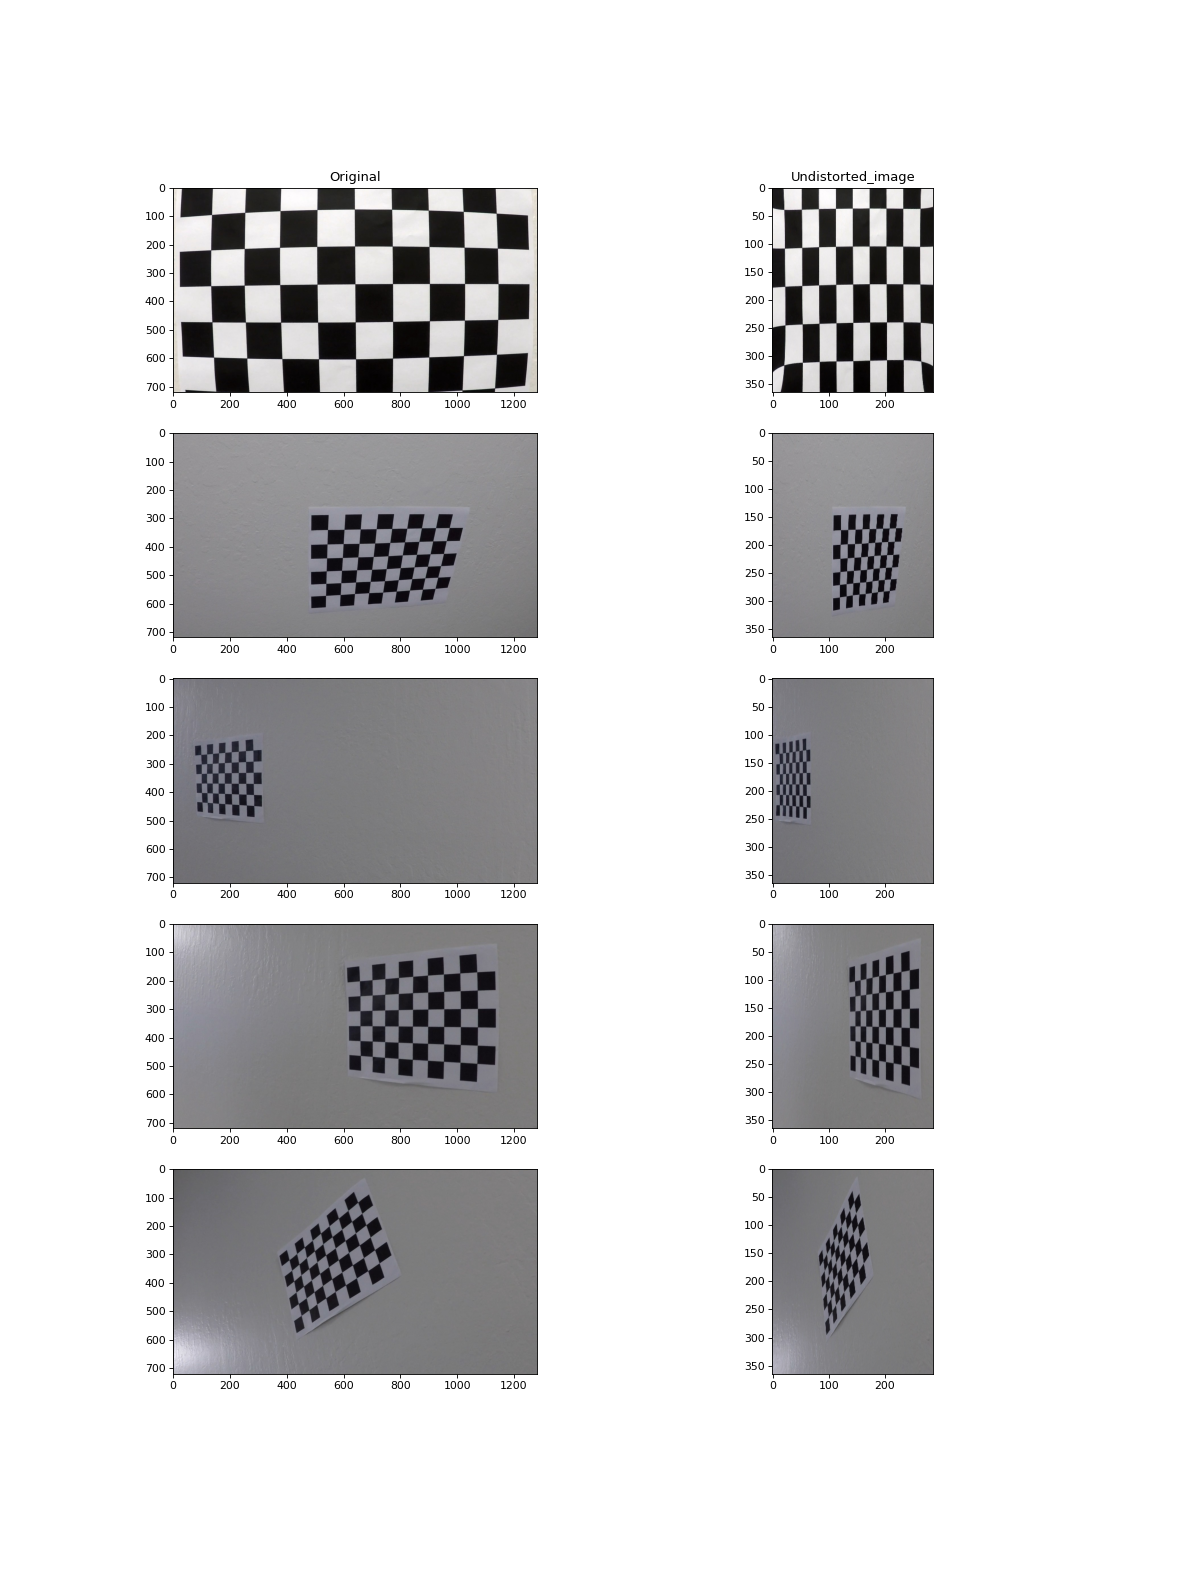

In [10]:
##Comparing Undistorded and Distorded Image
nrows=5
fig,axes=plt.subplots(5,2,figsize=(15,20))
for i in range(nrows):
    img=cv.imread(images_list[i])
    undist_img=get_undistord_image(img,objpoints=objpoints,imgpoints=imagepoints)
    axes[i][0].imshow(cv.cvtColor(img,cv.COLOR_BGR2RGB))
    axes[i][1].imshow(cv.cvtColor(undist_img,cv.COLOR_BGR2RGB))
    if i==0:
        axes[i][0].set_title('Original')
        axes[i][1].set_title('Undistorted_image')

In [10]:
### Perspective Transorm
## Transform image in bird eye view 

In [11]:
## Working with an example
persective_img_dire=os.path.join('images/Perspective/1.jpg')

In [12]:
test_img=cv.imread(persective_img_dire)

In [13]:
cv.imshow('test_img',test_img)
cv.waitKey(0)
cv.destroyAllWindows()

<IPython.core.display.Javascript object>


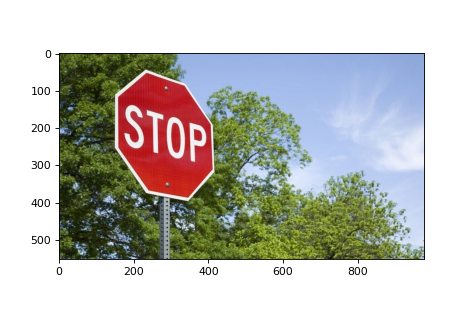

In [15]:
## For transformation we need 4 point in the tilted images ( Usually edge points)
## Let us observe these images in intercative  matplotlib plot
plt.imshow(cv.cvtColor(test_img,cv.COLOR_BGR2RGB))
plt.show()

In [16]:
p1=(403,186)
p2=(412,311)
p3=(148,244)
p4=(149,110)
## Seeing these points in images


<IPython.core.display.Javascript object>


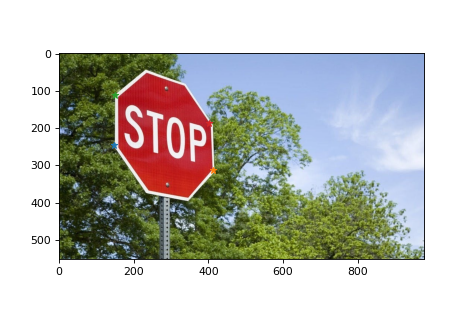

In [17]:
plt.imshow(cv.cvtColor(test_img,cv.COLOR_BGR2RGB))
plt.plot(148,244,'*',)
plt.plot(412,311,'*')
plt.plot(149,110,'*')
plt.plot(403,186,'*')
plt.show()


In [57]:
## Now applying perspective transform

In [18]:
def warp(img,p1,p2,p3,p4):
    img_size=(img.shape[1],img.shape[0])
    
    ## Source points
    src=np.float32([p1,p2,p3,p4])
    
    #Four desired function 
    dst=np.float32([(425,183),
                   (425,303),
                   (160,303),
                   (160,183)])
    
    ## Getting the perspective transform
    
    M=cv.getPerspectiveTransform(src,dst)
    #print(M)
    warped=cv.warpPerspective(img,M,img_size,flags=cv.INTER_LINEAR)
    return warped
    

<IPython.core.display.Javascript object>


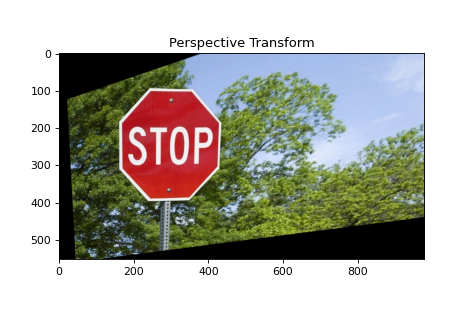

Text(0.5, 1.0, 'Perspective Transform')

In [19]:
warped=warp(test_img,p1,p2,p3,p4)
plt.imshow(cv.cvtColor(warped,cv.COLOR_BGR2RGB))
plt.title("Perspective Transform")

In [61]:
## Now its time to combine Perspective Transorfm with undistortion with chess_board images and see the images

In [20]:
def warp_img(img,objpoints,imgpoints,nx,ny):
    undist_img=get_undistord_image(img,objpoints,imagepoints)
    
    ret,corners=findcheese_corners(undist_img,(nx,ny))
    
    if ret:
        print("Corners exist")
        
        src=np.float32([corners[0],corners[nx-1],corners[-1],corners[-nx]])
        offset=40
        dst=np.float32([[offset,offset],[undist_img.shape[1]-offset,offset],
                       [undist_img.shape[1]-offset,undist_img.shape[0]-offset],[offset,undist_img.shape[0]-offset]])
        ##get Perspective Transform
        M=cv.getPerspectiveTransform(src,dst)
        wrap=cv.warpPerspective(undist_img,M,(undist_img.shape[1],undist_img.shape[0]),flags=cv.INTER_LINEAR)
        return wrap
    else:
        return False

        

In [25]:
def get_img_with_corner(img_list):
    new_img_list=[]
    image_list=np.array(list(map(lambda x:cv.imread(x),images_list)))
    img_with_corners=np.array(list(map(lambda x:findcheese_corners(x,(nx,ny)),image_list)))
    for n,i in enumerate(img_with_corners):
        #print(i[0])
        if i[0]==True:
            new_img_list.append(img_list[n])
            
    return new_img_list

In [26]:
new_img_list=get_img_with_corner(images_list)

C:\Users\akash\AppData\Local\Temp/ipykernel_25888/1344998677.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  image_list=np.array(list(map(lambda x:cv.imread(x),images_list)))
C:\Users\akash\AppData\Local\Temp/ipykernel_25888/1344998677.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  img_with_corners=np.array(list(map(lambda x:findcheese_corners(x,(nx,ny)),image_list)))


<IPython.core.display.Javascript object>


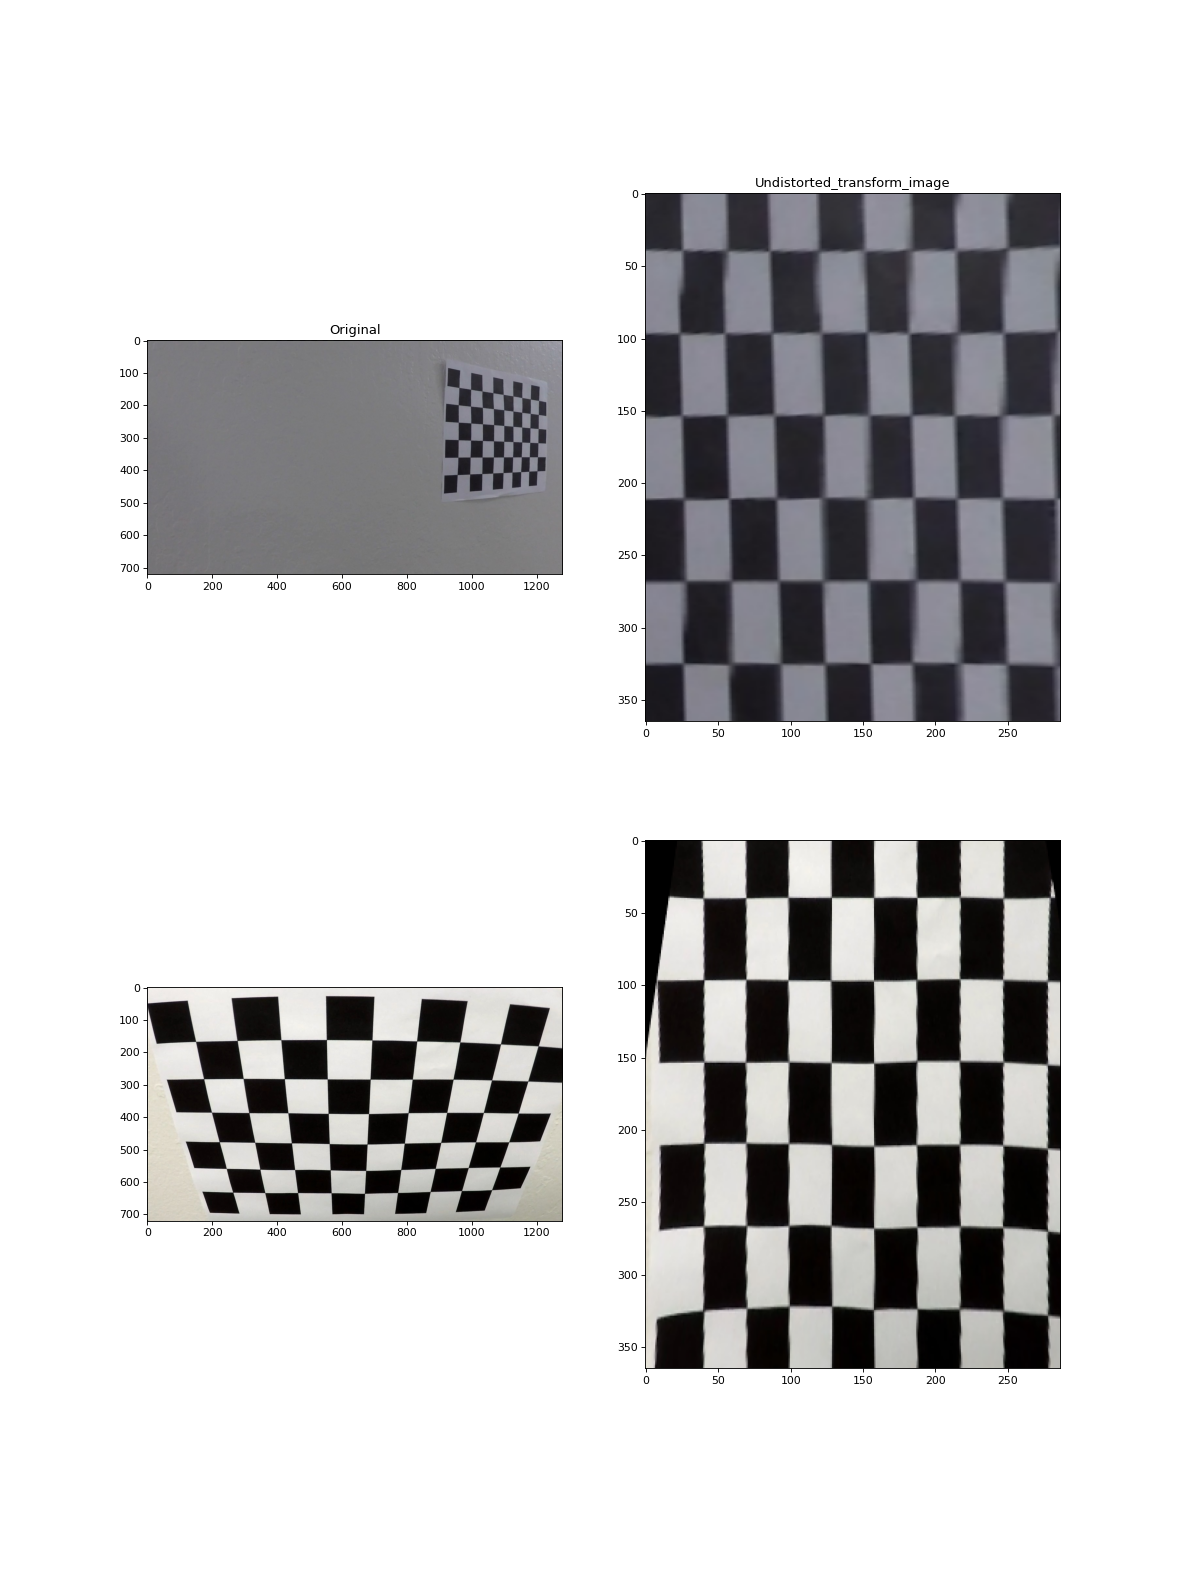

Corners exist
Corners exist


In [28]:
nrows=len(new_img_list)
fig,axes=plt.subplots(nrows,2,figsize=(15,20))
for i in range(nrows):
    img=cv.imread(new_img_list[i])
    undist_transform_img=warp_img(img,objpoints,imagepoints,nx,ny)
    axes[i][0].imshow(cv.cvtColor(img,cv.COLOR_BGR2RGB))
    axes[i][1].imshow(cv.cvtColor(undist_transform_img,cv.COLOR_BGR2RGB))
    if i==0:
        axes[i][0].set_title('Original')
        axes[i][1].set_title('Undistorted_transform_image')

In [27]:
new_img_list

['images\\calibration\\calibration14.jpg',
 'images\\calibration\\calibration2.jpg']